In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc
)


In [2]:
# Step 1: Generate synthetic data (replace this with your actual data)
np.random.seed(42)
data = {
    "product_id": np.arange(1, 1001),
    "return_rate": np.random.uniform(0, 1, 1000),  # Fraction of returns for this product
    "avg_rating": np.random.uniform(1, 5, 1000),  # Average product rating
    "price": np.random.uniform(10, 500, 1000),  # Product price
    "price_variance_over_time": np.random.uniform(0, 50, 1000),  # Price fluctuation over time
    "seller_rating": np.random.uniform(1, 5, 1000),  # Seller rating
    "country_code": np.random.choice(["US", "UK", "IN", "DE"], size=1000),  # Country code
    "category": np.random.choice(["Electronics", "Clothing", "Home", "Toys"], size=1000),
    "refund_reason_code": np.random.choice(
        ["incorrect description", "wrong size", "damaged", "other"], size=1000
    ),
    "is_likely_returned": np.random.choice([0, 1], size=1000, p=[0.7, 0.3])  # Target variable
}

df = pd.DataFrame(data)


In [3]:
df.head()

,product_id,return_rate,avg_rating,price,price_variance_over_time,seller_rating,country_code,category,refund_reason_code,is_likely_returned
0,1,0.374540,1.740532,138.235785,33.635150,3.287984,IN,Clothing,incorrect description,0
1,2,0.950714,3.167604,131.019612,39.834070,4.221729,DE,Home,incorrect description,0
2,3,0.731994,4.491783,454.064744,12.523395,4.040644,IN,Toys,damaged,0
3,4,0.598658,3.928900,132.277638,31.243705,1.615600,DE,Home,incorrect description,0
4,5,0.156019,4.226245,143.255366,28.587299,1.596998,DE,Home,incorrect description,0


In [4]:
# Step 2: Preprocess data
# Convert categorical variables into numerical features (one-hot encoding)
df = pd.get_dummies(df, columns=["category", "refund_reason_code", "country_code"], drop_first=True)

# Feature selection
features = (
    ["return_rate", "avg_rating", "price", "price_variance_over_time", "seller_rating"]
    + [col for col in df.columns if "category_" in col]
    + [col for col in df.columns if "refund_reason_code_" in col]
    + [col for col in df.columns if "country_code_" in col]
)
X = df[features]
y = df["is_likely_returned"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Step 3: Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [6]:
# Step 4: Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of being returned


In [7]:
# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84       151
           1       0.11      0.02      0.03        49

    accuracy                           0.72       200
   macro avg       0.43      0.48      0.44       200
weighted avg       0.59      0.72      0.64       200



In [8]:
# Step 6: Identify products likely to be returned
X_test["predicted_return"] = y_pred
X_test["return_probability"] = y_pred_prob
X_test["product_id"] = df.loc[X_test.index, "product_id"]
returned_products = X_test[X_test["predicted_return"] == 1]

print("Products Likely to be Returned:\n", returned_products[["product_id", "return_probability"]])

Products Likely to be Returned:
      product_id  return_probability
883         884                0.53
299         300                0.51
107         108                0.58
67           68                0.55
528         529                0.58
978         979                0.55
294         295                0.63
237         238                0.59
259         260                0.61


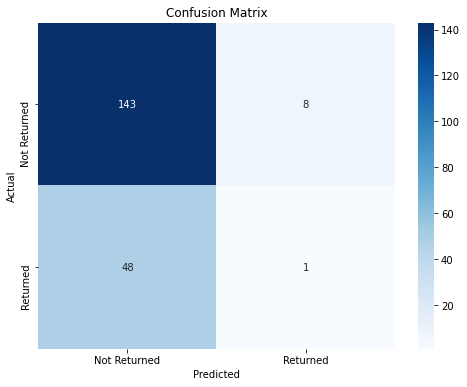

In [9]:
# Visualization 1: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Returned", "Returned"], yticklabels=["Not Returned", "Returned"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


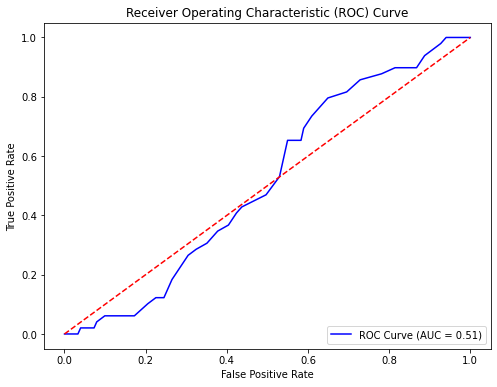

In [10]:
# Visualization 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


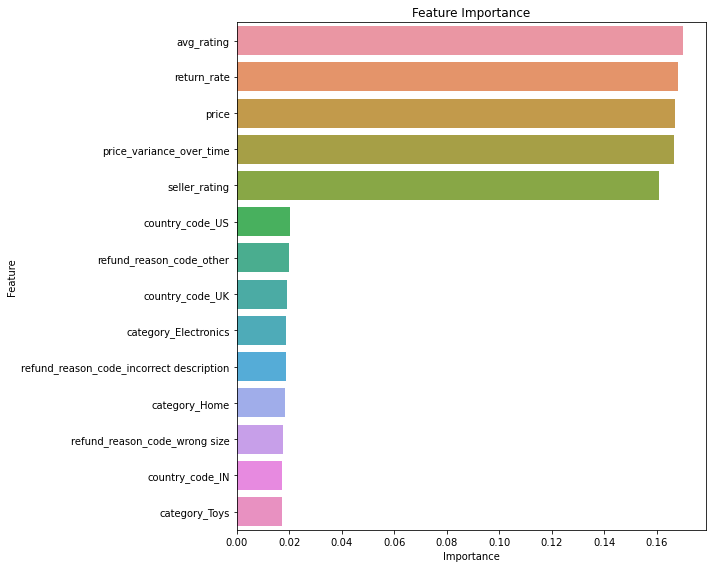

In [11]:
# Visualization 3: Feature Importance
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()